# Latent Factor Collaborative Filtering Recommender System - 
## MovieLens Database

In [3]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import seaborn as sns; sns.set(style="white", color_codes=True)
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Data

MovieLens 1M Dataset
Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.

README.txt
ml-1m.zip (size: 6 MB, checksum)
Permalink: http://grouplens.org/datasets/movielens/1m/

### Read In Data

In [4]:
user_movies = pd.read_csv('data/ratings20.csv')

In [5]:
user_movies.columns = ['userid', 'movieid', 'rating', 'timestamp']
user_movies.head(15)

,userid,movieid,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


#### Check for multiple ratings by same user for same movie

In [66]:
### Group by user
user_movies[user_movies.duplicated(subset=['userid', 'movieid'])==True]

,userid,movieid,rating,timestamp


##### Check Distribution of Ratings

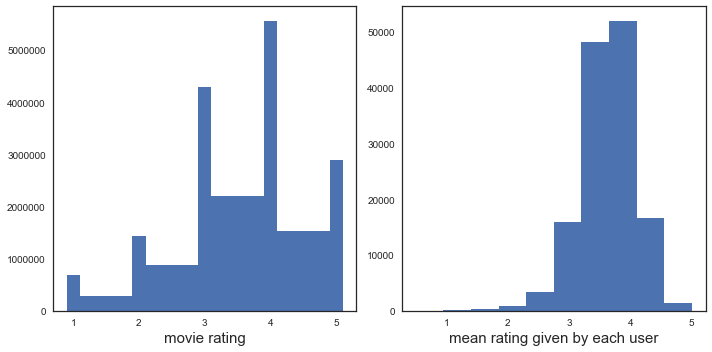

In [67]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist(user_movies['rating'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('movie rating', fontsize=15)

# mean ratings from each user
mean_rating_of_user = user_movies.groupby('userid').apply(lambda x: x['rating'].mean())
ax = fig.add_subplot(122)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=15)
plt.tight_layout()
plt.show()

The distribution is somewhat skewed towards positive reviews, so we will apply normalization to reduce the effect of magnitude

#### Number of reviews and movies

In [12]:
n_users = user_movies['userid'].unique().shape[0]
n_items = user_movies['movieid'].unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' movies')

138493 users
26744 movies


In [14]:
user_movies.shape

(20000263, 4)

##### Construct User-movie Matrix

In [15]:
import scipy.sparse as sparse

def create_sparse(df):
#     users_list = list(df['userid'])
#     movieid_list = list(df['movieid'])
#     rating_list = list(df['rating'])
    
    users = list(np.sort(df['userid'].unique()))
    movieids = list(df['movieid'].unique())
    ratings = list(df['rating'])

    rows = df['userid'].astype('category', categories = users).cat.codes
    cols = df['movieid'].astype('category', categories = movieids).cat.codes

    
#     return sparse.csr_matrix((rating_list, (users_list, movieid_list)))
    return sparse.csr_matrix((ratings, (rows, cols)), 
                            shape=(len(users), len(movieids)))

In [16]:
ratings_sparse = create_sparse(user_movies)
ratings_sparse.shape

(138493, 26744)

In [17]:
print(ratings_sparse)

  (0, 0)	3.5
  (0, 1)	3.5
  (0, 2)	3.5
  (0, 3)	3.5
  (0, 4)	3.5
  (0, 5)	3.5
  (0, 6)	4.0
  (0, 7)	4.0
  (0, 8)	4.0
  (0, 9)	4.0
  (0, 10)	4.0
  (0, 11)	4.0
  (0, 12)	4.0
  (0, 13)	3.5
  (0, 14)	3.5
  (0, 15)	4.0
  (0, 16)	3.5
  (0, 17)	3.5
  (0, 18)	3.0
  (0, 19)	3.5
  (0, 20)	3.5
  (0, 21)	3.5
  (0, 22)	4.0
  (0, 23)	4.0
  (0, 24)	3.5
  :	:
  (138492, 5844)	3.0
  (138492, 5970)	5.0
  (138492, 6121)	4.5
  (138492, 6156)	4.5
  (138492, 6565)	3.5
  (138492, 6591)	5.0
  (138492, 7124)	5.0
  (138492, 7315)	3.5
  (138492, 7421)	4.0
  (138492, 7557)	4.0
  (138492, 7717)	4.0
  (138492, 7722)	4.5
  (138492, 7733)	4.5
  (138492, 7953)	5.0
  (138492, 8056)	5.0
  (138492, 8233)	5.0
  (138492, 8890)	5.0
  (138492, 9527)	4.0
  (138492, 9547)	4.5
  (138492, 9648)	4.5
  (138492, 9787)	4.5
  (138492, 10743)	4.5
  (138492, 11011)	4.5
  (138492, 11504)	5.0
  (138492, 11614)	4.5


##### Check user-item matrix sparsity

In [18]:
def get_sparsity(sparse_mat):
    matrix_size = sparse_mat.shape[0] * sparse_mat.shape[1] # Number of possible interactions in the matrix
    num_purchases = len(sparse_mat.nonzero()[0]) # Number of items interacted with
    sparsity = 100 * (1 - (num_purchases / matrix_size))
    
    return sparsity

print(get_sparsity(ratings_sparse))

99.46001521864456


Not bad. Our user-movies matrix consists of 99.46% unfilled entries. Let's experiment with reducing the sparsity using the N-core method, i.e. each user will have rated at least N movies and each movie will have at least N reviews.

##### Check Distribution on Number of Items Rated by Users and Items Rated by Number of Users

In [21]:
min_rated_items = ratings_sparse.nonzero()[0]
min_rated_items_collection = {}
for i in min_rated_items:
    if i in min_rated_items_collection:
        min_rated_items_collection[i] = min_rated_items_collection[i] + 1
    else:
        min_rated_items_collection[i] = 1

In [22]:
user_rate_count = sorted(min_rated_items_collection.items(), key = lambda x:x[1])
print('Users rated ', user_rate_count[-1][1], 'movies at the most')
print('Users rated ', user_rate_count[0][1], 'movies at the least')

Users rated  9254 movies at the most
Users rated  20 movies at the least


In [23]:
min_rate_by_users = ratings_sparse.nonzero()[1]
min_rate_by_users_collection = {}
for i in min_rate_by_users:
    if i in min_rate_by_users_collection:
        min_rate_by_users_collection[i] = min_rate_by_users_collection[i] + 1
    else:
        min_rate_by_users_collection[i] = 1
item_rate_count = sorted(min_rate_by_users_collection.items(), key = lambda x:x[1])

In [24]:
print ('Item rated by ', item_rate_count[-1][1], ' users at the most')
print ('Item rated by ', item_rate_count[0][1], ' users at the least')

Item rated by  67310  users at the most
Item rated by  1  users at the least


**Because the data is so large, I will have to reduce sparsity while the data is in pandas**

#### Count of ratings per user
Dataframe shows how many times people reviewed x items.
eg, 4485 users submitted 20 reviews total

In [25]:
# user_movies.groupby(['userid']).size().reset_index(name='review_counts').sort_values('review_counts')
temp = user_movies.groupby(['userid']).size().reset_index(name='review_counts')['review_counts'] \
            .value_counts(ascending=False).reset_index(name='counts').head(20)
temp.columns = ['count of reviews','count']
temp.head(10)

,count of reviews,count
0,20,4485
1,21,3104
2,22,2832
3,23,2641
4,25,2399
5,24,2365
6,26,2164
7,27,2016
8,28,2016
9,30,1934


Dataframe shows the number of reviews a movie received

In [26]:
user_movies.groupby(['movieid']).size().reset_index(name='movie_counts')['movie_counts'] \
            .value_counts(ascending=True)

8268        1
3096        1
1065        1
13359       1
3192        1
3208        1
1161        1
3224        1
3048        1
40106       1
17617       1
3288        1
1241        1
3304        1
5355        1
1273        1
7418        1
5291        1
1289        1
3032        1
11196       1
4827        1
2792        1
777         1
825         1
4923        1
2888        1
857         1
15310       1
2920        1
         ... 
31         92
24         96
26         97
23         98
35        101
29        105
28        112
25        114
22        124
21        139
20        143
19        143
18        164
16        173
15        190
17        195
14        234
13        264
12        290
11        294
10        372
9         385
8         462
7         574
6         647
5         826
4        1029
3        1355
2        2043
1        3972
Name: movie_counts, Length: 3423, dtype: int64

In [27]:
counts_m = user_movies['movieid'].value_counts()
counts_u = user_movies['userid'].value_counts()

### Experimenting with several sparsity modifiers

#### Baseline

In [47]:
print("After applying the filter, there are", ratings_sparse.shape[0], "users left")
print("After applying the filter, there are", ratings_sparse.shape[1], "items left")
print('Sparsity: {:4.2f}%'.format(get_sparsity(ratings_sparse)))

After applying the filter, there are 138493 users left
After applying the filter, there are 26744 items left
Sparsity: 99.46%


##### At least 100 reviews per movie and 20 reviews per user

In [39]:
short_user_movies = user_movies[(user_movies['movieid'].isin(counts_m[counts_m > 100].index)) & \
                                (user_movies['userid'].isin(counts_u[counts_u > 20].index))]
ratings_sparse2 = create_sparse(short_user_movies)

In [41]:
print("After applying the filter, there are", ratings_sparse2.shape[0], "users left")
print("After applying the filter, there are", ratings_sparse2.shape[1], "items left")
print('Sparsity: {:4.2f}%'.format(get_sparsity(ratings_sparse2)))

After applying the filter, there are 134008 users left
After applying the filter, there are 8532 items left
Sparsity: 98.28%


##### At least 200 reviews per movie and 40 reviews per user

In [42]:
short_user_movies = user_movies[(user_movies['movieid'].isin(counts_m[counts_m > 200].index)) & \
                                (user_movies['userid'].isin(counts_u[counts_u > 40].index))]
ratings_sparse2 = create_sparse(short_user_movies)

In [44]:
print("After applying the filter, there are", ratings_sparse2.shape[0], "users left")
print("After applying the filter, there are", ratings_sparse2.shape[1], "items left")
print('Sparsity: {:4.2f}%'.format(get_sparsity(ratings_sparse2)))

After applying the filter, there are 95482 users left
After applying the filter, there are 6744 items left
Sparsity: 97.17%


##### At least 400 reviews per movie and 80 reviews per user

In [48]:
short_user_movies = user_movies[(user_movies['movieid'].isin(counts_m[counts_m > 400].index)) & \
                                (user_movies['userid'].isin(counts_u[counts_u > 80].index))]
ratings_sparse2 = create_sparse(short_user_movies)

In [49]:
print("After applying the filter, there are", ratings_sparse2.shape[0], "users left")
print("After applying the filter, there are", ratings_sparse2.shape[1], "items left")
print('Sparsity: {:4.2f}%'.format(get_sparsity(ratings_sparse2)))

After applying the filter, there are 61262 users left
After applying the filter, there are 5003 items left
Sparsity: 94.84%


As we increase the filtering criteria, our sparsity decreases, but the total size of user-item matrix dramatically decreases. We will proceed with the original sparse matrix

## Latent Factor Based Methods

### ALS

In [8]:
from pyspark.shell import spark
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql import Row
import pyspark.sql.types as typ
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

spark = SparkSession \
    .builder \
    .appName("test") \
    .getOrCreate()

In [2]:
ratings_label = [('userId', typ.IntegerType()),
                  ('movieId', typ.IntegerType()),
                  ('rating', typ.FloatType()),
                  ('timestamp', typ.IntegerType())]

schema_ratings = typ.StructType([typ.StructField(e[0], e[1]) for e in ratings_label])

In [3]:
# ratings = spark.read.csv("data/ratings20.csv", schema=schema_ratings, header=True)

In [68]:
movies = spark.read.csv("data/movies20.csv", header=True)

In [19]:
movies = movies.select(movies.movieId.alias('movieid2'), movies.title)

In [20]:
movies.show(5)

+--------+--------------------+
|movieid2|               title|
+--------+--------------------+
|       1|    Toy Story (1995)|
|       2|      Jumanji (1995)|
|       3|Grumpier Old Men ...|
|       4|Waiting to Exhale...|
|       5|Father of the Bri...|
+--------+--------------------+
only showing top 5 rows



In [4]:
# ratings.write.parquet('data/ratings.parquet')
ratings = spark.read.parquet('data/ratings20.parquet')
ratings = ratings.repartition(200)

200

In [24]:
ratings_title = ratings.join(movies, ratings.movieId == movies.movieid2)

In [26]:
ratings_title = ratings_title.select(ratings_title.userId, ratings_title.movieId,
                                     ratings_title.rating, ratings_title.title)

In [27]:
(training, test) = ratings.randomSplit([0.8, 0.2])
training.cache()
test.cache()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

### Optimization of ALS Parameters

In [16]:
regParams = [0.001, 0.01, 0.1, 1]

In [7]:
out1 = [evaluator.evaluate(ALS(maxIter=10, regParam=x, implicitPrefs=False, alpha=1, rank=10,
                              userCol="userId", itemCol="movieId", ratingCol="rating",
                              coldStartStrategy="drop", seed=69) \
                            .fit(training).transform(test)) \
                            for x in regParams]

In [64]:
for i,v in enumerate(regParams):
    print ("RMSE on Test with Regularization at", v, ": {:4.6f}".format(out1[i]))

RMSE on Test with Regularization at 0.001 : 1.338930
RMSE on Test with Regularization at 0.01 : 1.162142
RMSE on Test with Regularization at 0.1 : 0.917396
RMSE on Test with Regularization at 1 : 1.332803


Text(0,0.5,'RMSE')

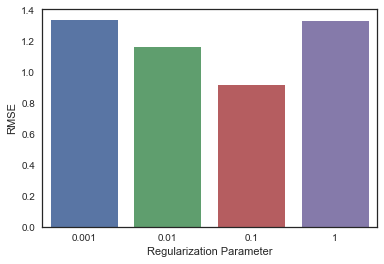

In [57]:
str_params = [str(x) for x in regParams]
sns.barplot(str_params, [i for i in out1])

plt.xlabel('Regularization Parameter')
plt.ylabel('RMSE')

In [59]:
alphaParams = [0.001, 0.01, 0.1, 1]

In [60]:
out2 = [evaluator.evaluate(ALS(maxIter=10, regParam=0.1, implicitPrefs=False, alpha=x, rank=10,
                              userCol="userId", itemCol="movieId", ratingCol="rating",
                              coldStartStrategy="drop", seed=69) \
                            .fit(training).transform(test)) \
                            for x in alphaParams]

In [67]:
for i,v in enumerate(alphaParams):
    print ("RMSE on Test with Alpha at", v, ": {:4.6f}".format(out2[i]))

RMSE on Test with Alpha at 0.001 : 0.917396
RMSE on Test with Alpha at 0.01 : 0.917396
RMSE on Test with Alpha at 0.1 : 0.917396
RMSE on Test with Alpha at 1 : 0.917396


Text(0,0.5,'RMSE')

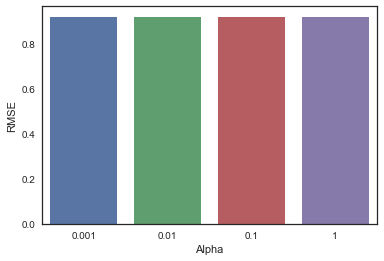

In [66]:
str_params = [str(x) for x in alphaParams]
sns.barplot(str_params, [i for i in out2])

plt.xlabel('Alpha')
plt.ylabel('RMSE')

In [69]:
latent_f = [5,10,15,20]

In [70]:
out3 = [evaluator.evaluate(ALS(maxIter=10, regParam=0.1, implicitPrefs=False, alpha=1, rank=x,
                              userCol="userId", itemCol="movieId", ratingCol="rating",
                              coldStartStrategy="drop", seed=69) \
                            .fit(training).transform(test)) \
                            for x in latent_f]

In [71]:
for i,v in enumerate(latent_f):
    print ("RMSE on Test with", v, "latent factors: {:4.6f}".format(out3[i]))

RMSE on Test with 5 latent factors: 0.914191
RMSE on Test with 10 latent factors: 0.917396
RMSE on Test with 15 latent factors: 0.915176
RMSE on Test with 20 latent factors: 0.913963


Text(0,0.5,'RMSE')

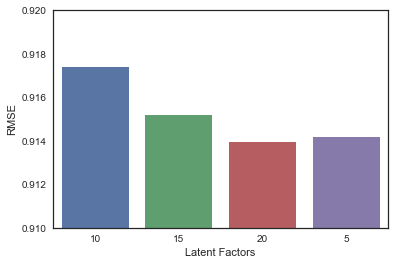

In [92]:
str_params = [str(x) for x in latent_f]
sns.barplot(str_params, [i for i in out3])
plt.ylim(0.91, 0.92)

plt.xlabel('Latent Factors')
plt.ylabel('RMSE')

### Best Params
regParam=0.1<br/>alpha=1<br/>rank=20

In [28]:
als = ALS(maxIter=10, regParam=0.1, implicitPrefs=False, alpha=1, rank=20,
                              userCol="userId", itemCol="movieId", ratingCol="rating",
                               seed=69)
model = als.fit(training)

In [29]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [9]:
# userRecs.write.parquet('data/userRecs.parquet')
# movieRecs.write.parquet('data/movieRecs.parquet')
userRecs = spark.read.parquet('data/userRecs.parquet')
movieRecs = spark.read.parquet('data/movieRecs.parquet')

In [71]:
ur2 = userRecs.withColumn("tmp", func.explode("recommendations")) \
    .select(userRecs.userId, func.col("tmp.movieId").alias("movieid"), func.col("tmp.rating").alias("rating"))

In [73]:
ur_movies = ur2.join(movies, ur2.movieid == movies.movieId)

In [77]:
ur_movies.select(ur_movies.userId, ur_movies.title).show(truncate=False)

+------+----------------------------------------+
|userId|title                                   |
+------+----------------------------------------+
|114   |Crazy Stone (Fengkuang de shitou) (2006)|
|114   |Bob Funk (2009)                         |
|114   |The War at Home (1979)                  |
|114   |Unbeatable (Ji zhan) (2013)             |
|114   |Octopus, The (Le poulpe) (1998)         |
|114   |I Belong (Som du ser meg) (2012)        |
|114   |Björk: Volumen (1999)                   |
|114   |Freedom Song (2000)                     |
|114   |Moth, The (Cma) (1980)                  |
|114   |Bill Hicks: Sane Man (1989)             |
|173   |Kevin Smith: Too Fat For 40 (2010)      |
|173   |Smashing Pumpkins: Vieuphoria (1994)    |
|173   |Drained (O cheiro do Ralo) (2006)       |
|173   |Mutant Aliens (2001)                    |
|173   |Yesterday Was a Lie (2008)              |
|173   |Bill Hicks: Sane Man (1989)             |
|173   |Code Name Coq Rouge (1989)              |
